In [31]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import iris

In [32]:
fdir='/badc/srip/data/zonal/common_grid/era_interim/'
fpath='TEM_monthly_2000_01.nc'

ds = xr.open_mfdataset(fdir+fpath)
# ds = ds.where( ds.pressure > 20., drop=True)
ds

<xarray.Dataset>
Dimensions:         (time: 1, pressure: 22, latitude: 73)
Coordinates:
  * time            (time) datetime64[ns] 2000-01-14T09:00:00
  * pressure        (pressure) float32 1e+03 925.0 850.0 700.0 ... 3.0 2.0 1.0
  * latitude        (latitude) float32 -90.0 -87.5 -85.0 ... 85.0 87.5 90.0
Data variables: (12/37)
    EPF_p_qg        (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_phi_qg      (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_p_qg       (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_phi_qg     (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_p_pr        (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_phi_pr      (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    ...              ...
    EPFD_p_qg_k3    (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_phi_qg_k3  (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_p_pr_k3     (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_phi_pr_k3   (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_p_pr_k3    (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_phi_pr_k3  (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
Attributes:
    Title:                     Transformed Eulerian Mean (TEM) diagnostics / ...
    Description:               EP flux and other terms from the TEM equations...
    Reanalysis:                era_interim
    Project_Homepage:          http://s-rip.ees.hokudai.ac.jp/
    SPARC_Homepage:            http://www.sparc-climate.org/
    Author:                    Patrick Martineau
    Report_issues_with_data:   patrick.martineau2@mail.mcgill.ca
    Creation_Date:             25-Oct-2017 08:49:08
    history:                   Wed Oct 25 08:49:08 2017: ncra /data/A/SRIP_da...
    nco_openmp_thread_number:  1

![DivF](DivF.png)

# Testing my function

In [33]:
def pressure_scaling(da, p0=1e3, multiply_factor=True):
    
    """
        Converts log-pressure coordinates to pressure coordinates
        or visa versa.
        ----------------------------------------------------------
        
        Input: xr.DataArray in log-pressure/pressure coordinates
                - (pressure, latitude)
        
        Output: xr.DataArray in pressure/log-pressure coordinates
                - (pressure, latitude)
    """
    
    # define dimensions
    lat = da.latitude.values
    level = da.pressure.values
    
    # define and calculate ratio
    p_ratio = np.repeat(level/p0, lat.size).reshape((level.size,lat.size))
    
    if multiply_factor:
        da_new = da * p_ratio
    else:
        da_new = da / p_ratio
        
    return da_new

In [34]:
def div_Fphi(ds, which_Fphi='EPF_phi_pr', apply_scaling=True, multiply_factor=True):
    
    """
        Calculate divergence of northward component
        of EP flux, F_phi. Including an optional 
        scaling from log-pressure to pressure coords.
        
        ----------------------------------------------
        
        Input: xr.Dataset containing epfy/Fy/Fphi [m3 s-2]
        
        Out: xr.DataArray Div_Fphi
    """
    
    # define DataArray
    Fphi = ds[which_Fphi]                                                       # [m3 s-2]
    
    if apply_scaling:
        Fphi = pressure_scaling(Fphi, multiply_factor=multiply_factor)
            
    
    # convert lat to radians take np.cos and multiply by Fphi (inside derivative)
    lat_rads = np.deg2rad(ds.latitude.values)
    coslat = np.cos(lat_rads)  
    F_coslat = Fphi * coslat

    # calc derivative and convert lat dimension to radians
    # mistake here was taking derivative not in radians!!
    F_coslat['latitude'] = lat_rads
    deriv1 = F_coslat.differentiate('latitude')                                 # [m2 s-2]
    
    # Divide by a cos(φ)
    a = 6.371e6
    div_Fphi = deriv1 / (a * coslat)                                            # [m s-2]
    
    # Divide by a cos(φ) AGAIN for whatever reason
    div_Fphi = div_Fphi / (a * coslat)                                          # [m s-2]
    
    return div_Fphi

### Without scaling

In [35]:
divF = div_Fphi(ds, apply_scaling=False)
divF = divF[0]

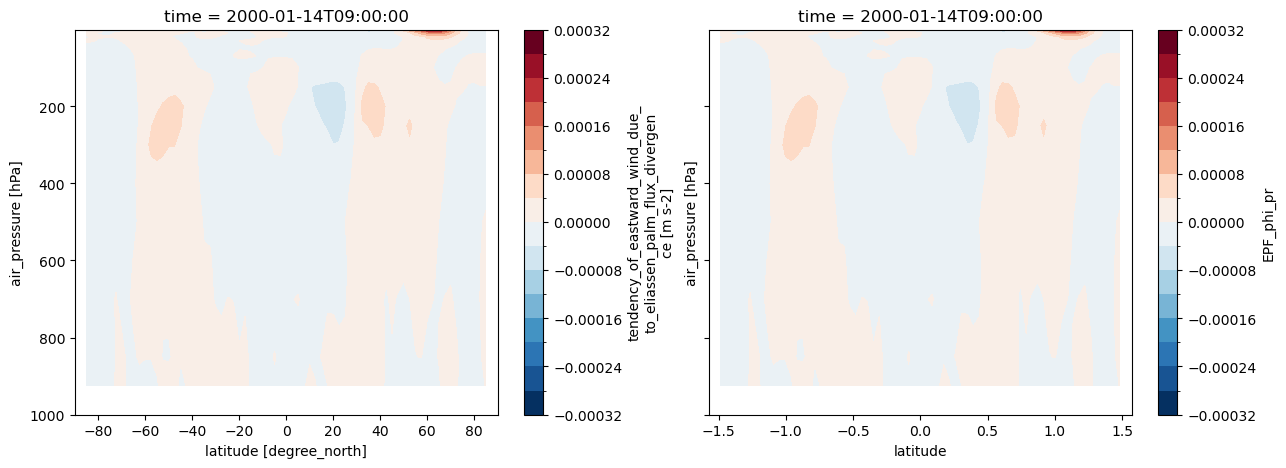

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5), sharey=True)

ds.EPFD_phi_pr[0].plot.contourf(ax=ax1, levels=20, yincrease=False)

divF.plot.contourf(ax=ax2, levels=20, yincrease=False)

In [37]:
np.testing.assert_allclose(ds.EPFD_phi_pr[0].values, divF.values, rtol=1e-3)

### With pressure scaling

In [38]:
divF = div_Fphi(ds)
divF = divF[0]

ds['EPFD_phi_pr'] = pressure_scaling(ds['EPFD_phi_pr'])

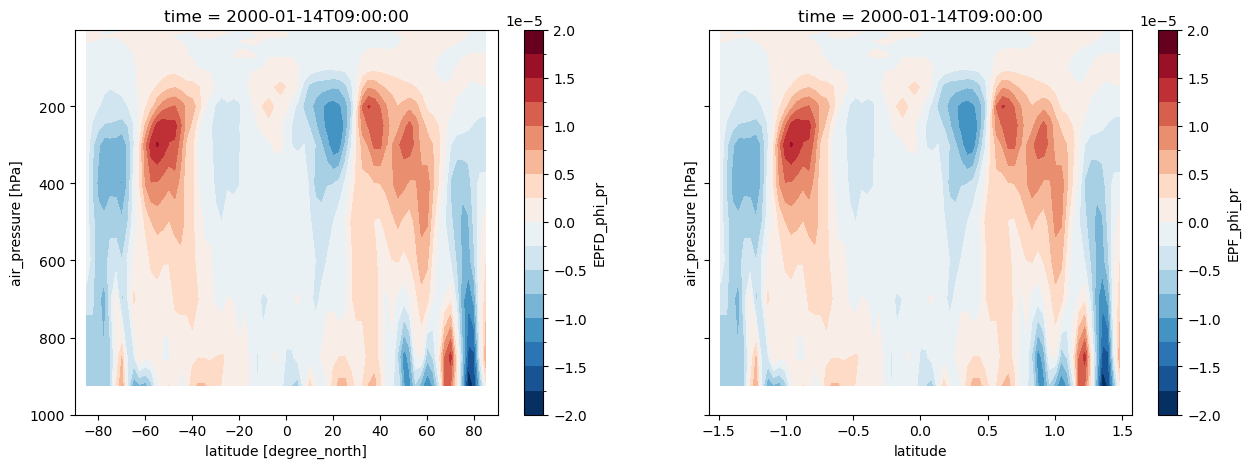

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5), sharey=True)

ds.EPFD_phi_pr[0].plot.contourf(ax=ax1, levels=20, yincrease=False)

divF.plot.contourf(ax=ax2, levels=20, yincrease=False)

In [40]:
np.testing.assert_allclose(ds.EPFD_phi_pr[0].values, divF.values, rtol=1e-3)